**IMPORTING IMPORTANT LIBRARIES**

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

**LOADING DATASET**

In [2]:
df=pd.read_csv('/content/IMDB Dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


# **PERFORMING EDA**




In [3]:
df.shape


(50000, 2)

**Sentiment Value Counts**

<ipython-input-4-1bd3f67e5f72>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")


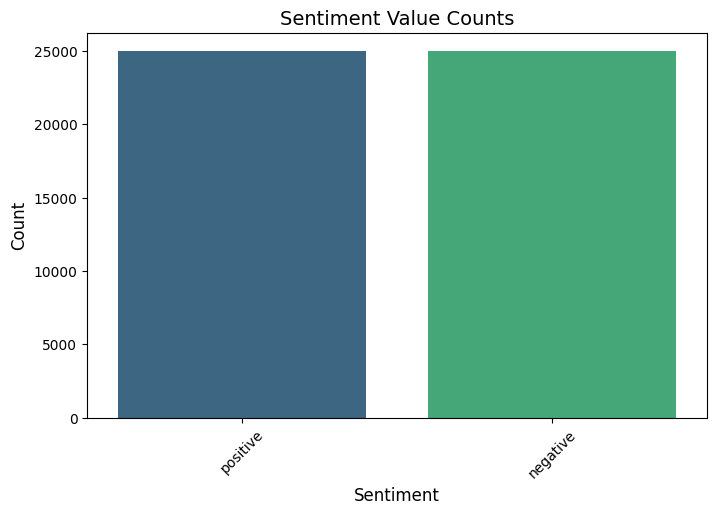

In [4]:
# 'df' is your DataFrame
sentiment_counts = df["sentiment"].value_counts()

# Plotting the bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")

# Adding labels and title
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Sentiment Value Counts", fontsize=14)
plt.xticks(rotation=45)
plt.show()



In [5]:
df.replace({"sentiment": {"positive": 1, "negative": 0}}, inplace=True)

<ipython-input-5-0554edc9e970>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({"sentiment": {"positive": 1, "negative": 0}}, inplace=True)


**Checking For Missing Values**

In [6]:
print("\nMissing Values:")
print(df.isnull().sum())



Missing Values:
review       0
sentiment    0
dtype: int64


**COLUMNS INFORMATION**

In [7]:
print("\nColumn Info:")
print(df.info())



Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB
None


**Summary Statistics**

In [8]:
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
          sentiment
count  50000.000000
mean       0.500000
std        0.500005
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000


**Distribution of Review Lengths**

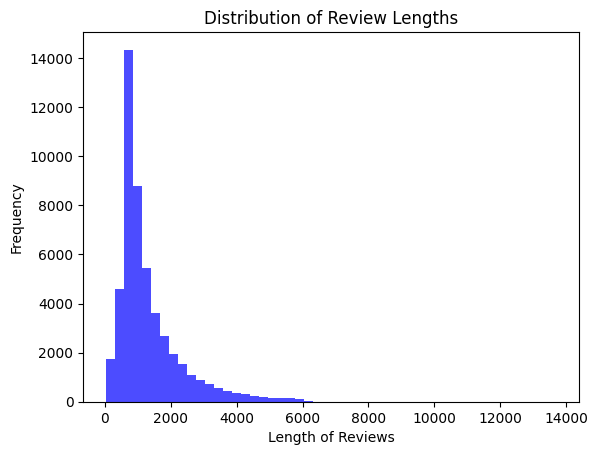

In [9]:
df['review_length'] = df['review'].apply(len)
plt.hist(df['review_length'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Review Lengths')
plt.xlabel('Length of Reviews')
plt.ylabel('Frequency')
plt.show()


**Most Common Words/Phrases Initially**

In [10]:
vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english', max_features=20)
word_counts = vectorizer.fit_transform(df['review'])
words = vectorizer.get_feature_names_out()

print("Most Common Words/Phrases:", words)


Most Common Words/Phrases: ['bad' 'br' 'br br' 'characters' 'don' 'film' 'good' 'great' 'just' 'like'
 'make' 'movie' 'movies' 'people' 'really' 'story' 'think' 'time' 'watch'
 'way']


**'Most Common Words/Phrases Bar Chart**

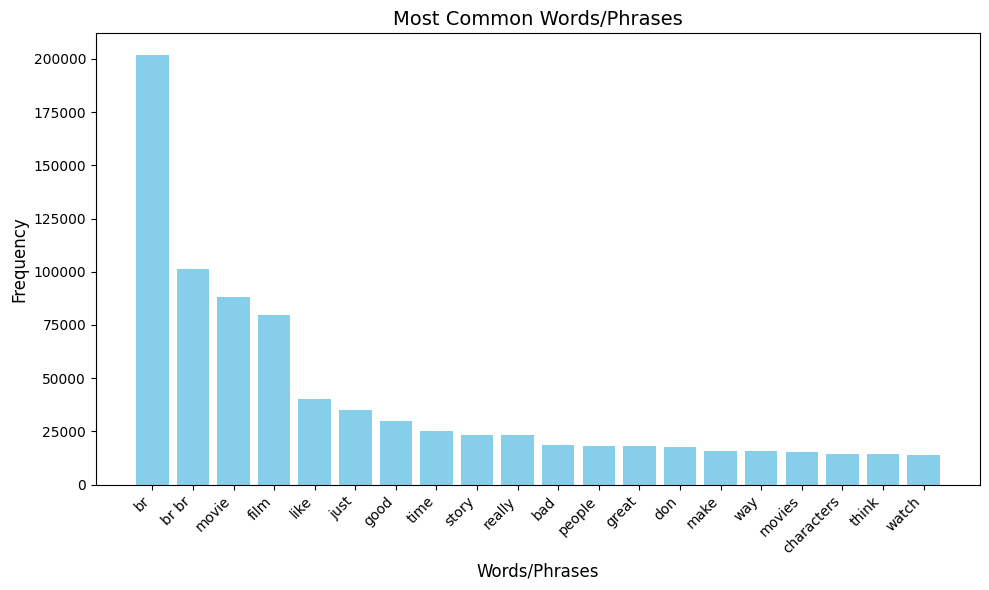

In [11]:
# Get the feature names and their corresponding counts
word_counts_array = word_counts.toarray().sum(axis=0)  # Summing counts across all rows
word_freq = pd.DataFrame({'word': vectorizer.get_feature_names_out(), 'count': word_counts_array})

# Sort by frequency in descending order
word_freq = word_freq.sort_values(by='count', ascending=False)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(word_freq['word'], word_freq['count'], color='skyblue')
plt.xlabel('Words/Phrases', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Most Common Words/Phrases', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**Review Length by Sentiment**

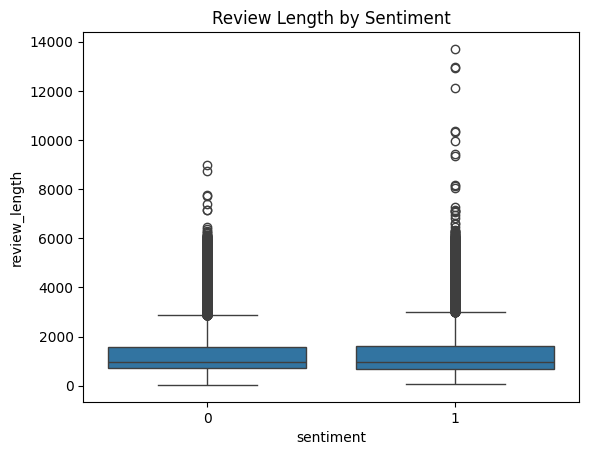

In [12]:
sns.boxplot(x='sentiment', y='review_length', data=df)
plt.title('Review Length by Sentiment')
plt.show()


**Cleaning REVIEW Column**

In [13]:
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove HTML tags, URLs, and special characters
    text = re.sub(r'<.*?>', '', text)       # Remove HTML tags
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove special characters and numbers

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into a single string
    return ' '.join(tokens)

**Apply preprocessing to the 'review' column**

In [14]:
df['review'] = df['review'].apply(preprocess_text)

# Check the first few rows of the cleaned reviews
print(df[['review']].head())


                                              review
0  one reviewer mentioned watching oz episode you...
1  wonderful little production filming technique ...
2  thought wonderful way spend time hot summer we...
3  basically there family little boy jake think t...
4  petter matteis love time money visually stunni...


**Most Common Words/Phrases After Cleaning Review**

In [15]:
vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english', max_features=20)
word_counts = vectorizer.fit_transform(df['review'])
words = vectorizer.get_feature_names_out()

print("Most Common Words/Phrases :", words)


Most Common Words/Phrases : ['bad' 'character' 'dont' 'film' 'good' 'great' 'know' 'life' 'like'
 'make' 'movie' 'people' 'really' 'scene' 'story' 'thing' 'think' 'time'
 'watch' 'way']


**Most Common Words/Phrases After CLEANING BAR-CHART**

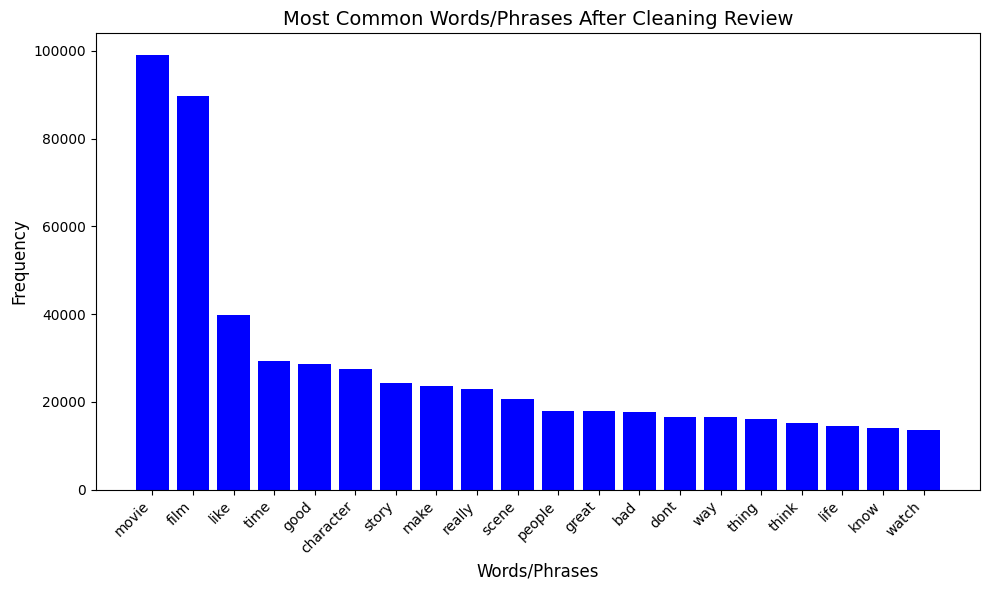

In [16]:
# Get the feature names and their corresponding counts
word_counts_array = word_counts.toarray().sum(axis=0)  # Summing counts across all rows
word_freq = pd.DataFrame({'word': vectorizer.get_feature_names_out(), 'count': word_counts_array})

# Sort by frequency in descending order
word_freq = word_freq.sort_values(by='count', ascending=False)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(word_freq['word'], word_freq['count'], color='blue')
plt.xlabel('Words/Phrases', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Most Common Words/Phrases After Cleaning Review', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


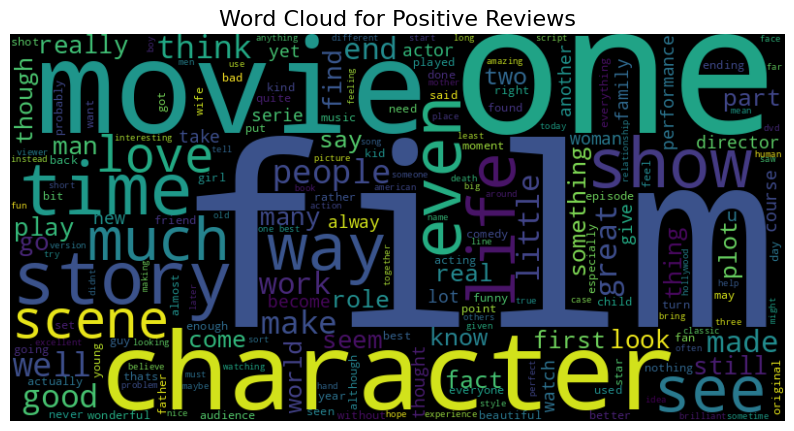

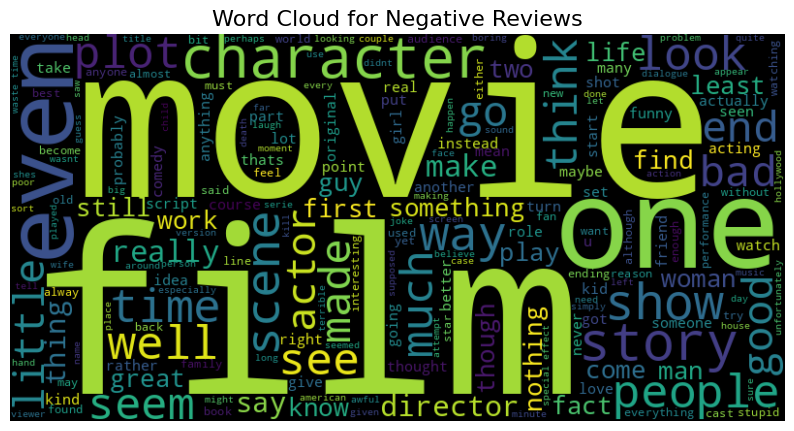

In [17]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color="black", colormap="viridis").generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

# Correct the filtering to account for numeric sentiment values
positive_reviews = " ".join(df[df['sentiment'] == 1]['review'])
negative_reviews = " ".join(df[df['sentiment'] == 0]['review'])

# Generate word clouds
generate_wordcloud(positive_reviews, "Word Cloud for Positive Reviews")
generate_wordcloud(negative_reviews, "Word Cloud for Negative Reviews")


**Split data into training data and test data**

In [18]:
X = df['review']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**TfidfVectorization**

In [19]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

**Naive-Bayes Model**

In [69]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)
nb_accuracy = accuracy_score(y_test, y_pred_nb)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Naive Bayes Performance:**

In [70]:
print("Naive Bayes Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb))
print("Recall:", recall_score(y_test, y_pred_nb))
print("F1 Score:", f1_score(y_test, y_pred_nb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))

Naive Bayes Performance:
Accuracy: 0.8491
Precision: 0.8474409448818898
Recall: 0.8543361778130582
F1 Score: 0.8508745923510228

Confusion Matrix:
 [[4186  775]
 [ 734 4305]]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Testing Naive Bayes Model**

In [22]:
def predict_sentiment_naive_bayes(review, vectorizer, model):

    # Transform the review using the vectorizer
    vectorized_review = vectorizer.transform([review])

    # Predict sentiment using the Naive Bayes model
    prediction = model.predict(vectorized_review)

    # Map the prediction to sentiment labels
    sentiment = "positive" if prediction[0] == 1 else "negative"
    return sentiment


In [61]:
new_review = "The movie was fantastic and truly heartwarming!"

# Predict sentiment
predicted_sentiment = predict_sentiment_naive_bayes(new_review, tfidf, nb_model)
print(f"The predicted sentiment is: {predicted_sentiment}")

The predicted sentiment is: positive


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [65]:
new_review = "The movie was so bad! I hated every moment."

# Predict sentiment
predicted_sentiment = predict_sentiment_naive_bayes(new_review, tfidf, nb_model)
print(f"The predicted sentiment is: {predicted_sentiment}")


The predicted sentiment is: negative


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**LOGISTIC REGRESSION MODEL**

In [71]:
# Initialize Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model on the training data
lr_model.fit(X_train_tfidf, y_train)

# Predict on the test data
y_pred_lr = lr_model.predict(X_test_tfidf)

lr_accuracy = accuracy_score(y_test, y_pred_lr)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**LOGISTIC REGRESSION PERFORMANCE**

In [26]:
# Evaluate the model
print("Accuracy of Logistic Regression:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))


Accuracy of Logistic Regression: 0.8848

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000


Confusion Matrix:
 [[4322  639]
 [ 513 4526]]


**Testing  LOGISTIC REGRESSION**

In [27]:
def predict_sentiment_logistic_regression(review, vectorizer, model):

    # Transform the review using the vectorizer
    vectorized_review = vectorizer.transform([review])

    # Predict sentiment using the Logistic Regression model
    prediction = model.predict(vectorized_review)

    # Map the prediction to sentiment labels
    sentiment = "positive" if prediction[0] == 1 else "negative"
    return sentiment



In [62]:
new_review = "The movie was fantastic and truly heartwarming!"

# Predict sentiment using Logistic Regression
predicted_sentiment = predict_sentiment_logistic_regression(new_review, tfidf, lr_model)
print(f"The predicted sentiment is: {predicted_sentiment}")

The predicted sentiment is: positive


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
new_review = "The movie was so bad! I hated every moment."

# Predict sentiment using Logistic Regression
predicted_sentiment = predict_sentiment_logistic_regression(new_review, tfidf, lr_model)
print(f"The predicted sentiment is: {predicted_sentiment}")

The predicted sentiment is: negative


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Naive Bayes VS LOGISTIC REGRESSION COMPARISION**

In [72]:
if nb_accuracy > lr_accuracy:
    print(f"Naive Bayes wins with an accuracy of {nb_accuracy:.2f} compared to Logistic Regression's {lr_accuracy:.2f}.")
elif lr_accuracy > nb_accuracy:
    print(f"Logistic Regression wins with an accuracy of {lr_accuracy:.2f} compared to Naive Bayes' {nb_accuracy:.2f}.")
else:
    print(f"It's a tie! Both models achieved an accuracy of {nb_accuracy:.2f}.")

Logistic Regression wins with an accuracy of 0.88 compared to Naive Bayes' 0.85.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Tokenizing Data**

In [30]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100)


In [31]:
print(X_train_seq)

[[  17  144   41 ...  121  129 3450]
 [   1 1463  576 ...  118   24   33]
 [   0    0    0 ...  212  613    8]
 ...
 [   0    0    0 ...  998  364  520]
 [   0    0    0 ... 1140  153   33]
 [   0    0    0 ...  316   16 1780]]


In [32]:
print(X_test_seq)

[[   0    0    0 ...  175  110  843]
 [1903 3306 4057 ...   33 1401   13]
 [   0    0    0 ...  818  937    1]
 ...
 [   0    0    0 ...  489   87 2101]
 [   0    0    0 ...    5   76 1722]
 [   0    0    0 ...   13  201    3]]


**LSTM MODEL**

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense


lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=128),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


 Model Summary

In [34]:

lstm_model.build(input_shape=(None, 100))
lstm_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 128)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 771,713 (2.94 MB)

 Trainable params: 771,713 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

**compiling the Model**

In [35]:
lstm_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

**RUNNING EPOCH**

In [36]:
lstm_model.fit(X_train_seq, y_train, batch_size=32, epochs=5, validation_data=(X_test_seq, y_test))

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.7879 - loss: 0.4434 - val_accuracy: 0.8736 - val_loss: 0.3097
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8992 - loss: 0.2585 - val_accuracy: 0.8724 - val_loss: 0.2996
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9186 - loss: 0.2136 - val_accuracy: 0.8721 - val_loss: 0.3136
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9354 - loss: 0.1713 - val_accuracy: 0.8713 - val_loss: 0.3467
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9512 - loss: 0.1339 - val_accuracy: 0.8615 - val_loss: 0.3647


**LSTM ACCURACY**

In [37]:
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_seq, y_test)
print("\nLSTM Performance:")
print("Accuracy:", lstm_accuracy)
print("Test Loss:", lstm_loss)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8567 - loss: 0.3691

LSTM Performance:
Accuracy: 0.8615000247955322
Test Loss: 0.3647410571575165


**Testing Model**

In [38]:
def predict_sentiment(review):
  # tokenize and pad the review
  sequence = tokenizer.texts_to_sequences([review])
  padded_sequence = pad_sequences(sequence, maxlen=200)
  prediction = lstm_model.predict(padded_sequence)
  sentiment = "positive" if prediction[0][0] > 0.5 else "negative"
  return sentiment

In [39]:
# example usage
new_review = "This movie was fantastic. I loved it."
sentiment = predict_sentiment(new_review)
print(f"The sentiment of the review is: {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
The sentiment of the review is: positive


In [40]:
# example usage
new_review = "Moive was really bad"
sentiment = predict_sentiment(new_review)
print(f"The sentiment of the review is: {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
The sentiment of the review is: negative


**Fit and Transform the Data**

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer
count_vectorizer = CountVectorizer(max_features=5000, stop_words='english')

# Fit and transform the data
X_counts = count_vectorizer.fit_transform(df['review'])


# ***Topic Modeling***







**Training LDA MODEL**

In [42]:
from sklearn.decomposition import LatentDirichletAllocation

# Initialize the LDA model
lda_model_sklearn = LatentDirichletAllocation(n_components=5, random_state=42)

# Fit the LDA model
lda_model_sklearn.fit(X_counts)


LatentDirichletAllocation(n_components=5, random_state=42)

**DISPLAY TOPICS**

In [43]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda_model_sklearn, count_vectorizer.get_feature_names_out(), no_top_words)


Topic 0:
film war people time movie world like series man story
Topic 1:
film character story movie time scene like great life make
Topic 2:
film movie great year time love best life role play
Topic 3:
movie like film good bad really dont time make watch
Topic 4:
film horror like scene good look little make killer time


In [44]:
!pip install pyLDAvis


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 38.2 MB/s eta 0:00:00


**Creating the Gensim corpus**

In [45]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.corpora.dictionary import Dictionary

# Tokenize reviews into lists of words
tokenized_reviews = [review.split() for review in df['review']]

# Create the Gensim dictionary
dictionary = Dictionary(tokenized_reviews)

# Create the Gensim corpus
gensim_corpus = [dictionary.doc2bow(text) for text in tokenized_reviews]

print("Gensim Dictionary and Corpus created successfully!")


Gensim Dictionary and Corpus created successfully!


**Intertopic Distance Map**

In [46]:
import pyLDAvis
import numpy as np

# Prepare inputs for pyLDAvis
doc_lengths = np.array(X_counts.sum(axis=1)).flatten()
term_frequency = np.array(X_counts.sum(axis=0)).flatten()
vocab = count_vectorizer.get_feature_names_out()

lda_vis_data = pyLDAvis.prepare(
    topic_term_dists=lda_model_sklearn.components_ / lda_model_sklearn.components_.sum(axis=1)[:, None],
    doc_topic_dists=lda_model_sklearn.transform(X_counts),
    doc_lengths=doc_lengths,
    vocab=vocab,
    term_frequency=term_frequency
)

# Display visualization
pyLDAvis.display(lda_vis_data)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Topic Distribution For Each Document**

In [47]:

topic_assignments = lda_model_sklearn.transform(X_counts)

# Assign the most probable topic to each review
df['Assigned_Topic_Sklearn'] = topic_assignments.argmax(axis=1)

# Save the dataset with assigned topics
df.to_csv('reviews_with_sklearn_topics.csv', index=False)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
# Display the first 10 reviews with their assigned topics
print("Sample Reviews with Assigned Topics:")
print(df[['review', 'Assigned_Topic_Sklearn']].head(10))

Sample Reviews with Assigned Topics:
                                              review  Assigned_Topic_Sklearn
0  one reviewer mentioned watching oz episode you...                       0
1  wonderful little production filming technique ...                       1
2  thought wonderful way spend time hot summer we...                       1
3  basically there family little boy jake think t...                       3
4  petter matteis love time money visually stunni...                       1
5  probably alltime favorite movie story selfless...                       2
6  sure would like see resurrection dated seahunt...                       3
7  show amazing fresh innovative idea first aired...                       3
8  encouraged positive comment film looking forwa...                       1
9  like original gut wrenching laughter like movi...                       3


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)




**Topic Distribution Across Reviews**



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


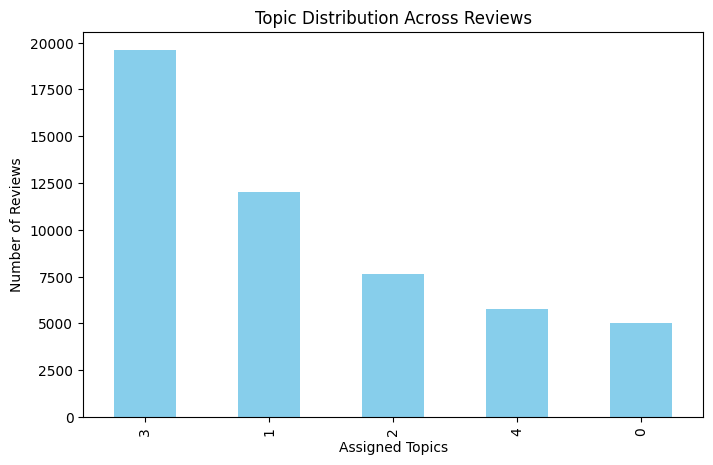

In [49]:
import matplotlib.pyplot as plt

# Plot the topic distribution
topic_counts = df['Assigned_Topic_Sklearn'].value_counts()
topic_counts.plot(kind='bar', color='skyblue', figsize=(8, 5))
plt.xlabel('Assigned Topics')
plt.ylabel('Number of Reviews')
plt.title('Topic Distribution Across Reviews')
plt.show()

**Dictionary of genres and their associated keywords**

In [50]:
import pandas as pd

genre_keywords = {
    "drama": ["realistic", "family", "character", "emotional", "struggle", "intense","life","relationship","conflict","tragic","oz","human relations"],
    "comedy": ["hilarious", "funny", "joke", "humor", "laugh", "lighthearted","comedy"],
    "romance": ["heartwarming", "affection", "romantic", "lovestory", "passion","titanic","jack","love story","relations","lighthearted"],
    "adventure": ["journey", "exotic", "wild", "quest", "exploration","adventure","hero"],
    "sci-fi": ["space", "robot", "technology","alien","scifi","planet","Star Trek","jedi"],
    "horror": ["creepy", "scary", "terrifying", "fear", "haunting", "blood","ghost","exorcism","supernatural","horror","vampire","zombie"],
    "mystery": ["secret", "clue", "detective", "investigation", "enigma", "whodunit"],
    "documentary": [ "biography", "history","quantum","documentary"],
    "animation": ["cartoon", "colorful", "drawn", "animated","anime","pixar","disney","sosuke"],
    "action": ["combat", "fight", "battle", "explosion", "adrenaline", "chase","martial","kungfu","gun","kill","stunt","heroes","hero"],
    "thriller": ["suspense", "twist", "crime", "danger", "tension", "mystery","thrill","Abre los Ojos","thriller"],
    "crime": ["murder", "detective", "law", "gang", "investigation", "police","brutality","serial killer"],
    "fantasy": ["magic", "wizard", "epic", "dragon", "mythical", "imaginative","king","prince","princess","barbie"],
}


# Function to extract genres based on keywords in the review
def extract_genre_from_review(review):
    matched_genres = []
    for genre, keywords in genre_keywords.items():
        if any(keyword in review.lower() for keyword in keywords):
            matched_genres.append(genre)
    return ", ".join(matched_genres) if matched_genres else "Unknown"



# Apply the function to extract genres
df['Genre'] = df['review'].apply(extract_genre_from_review)

# Save the updated dataset
df.to_csv('reviews_with_extracted_genres.csv', index=False)

# Display a sample of the updated dataset
print(df[['review', 'Genre']].head())


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                                              review  \
0  one reviewer mentioned watching oz episode you...   
1  wonderful little production filming technique ...   
2  thought wonderful way spend time hot summer we...   
3  basically there family little boy jake think t...   
4  petter matteis love time money visually stunni...   

                                   Genre  
0                   drama, action, crime  
1                          drama, comedy  
2  drama, comedy, romance, action, crime  
3        drama, horror, action, thriller  
4                                  drama  


**Topic Mapping**

In [51]:
topic_mapping = {
    0: "Acting and Performances",
    1: "Screenplay and Story",
    2: "Music and Soundtrack",
    3: "Visual Effects",
    4: "Emotional Impact"
}

# Map topics to themes
df['Assigned_Theme'] = df['Assigned_Topic_Sklearn'].map(topic_mapping)

# Display a sample
print(df[['review', 'Assigned_Topic_Sklearn', 'Assigned_Theme']].head(10))


                                              review  Assigned_Topic_Sklearn  \
0  one reviewer mentioned watching oz episode you...                       0   
1  wonderful little production filming technique ...                       1   
2  thought wonderful way spend time hot summer we...                       1   
3  basically there family little boy jake think t...                       3   
4  petter matteis love time money visually stunni...                       1   
5  probably alltime favorite movie story selfless...                       2   
6  sure would like see resurrection dated seahunt...                       3   
7  show amazing fresh innovative idea first aired...                       3   
8  encouraged positive comment film looking forwa...                       1   
9  like original gut wrenching laughter like movi...                       3   

            Assigned_Theme  
0  Acting and Performances  
1     Screenplay and Story  
2     Screenplay and Story  
3  

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


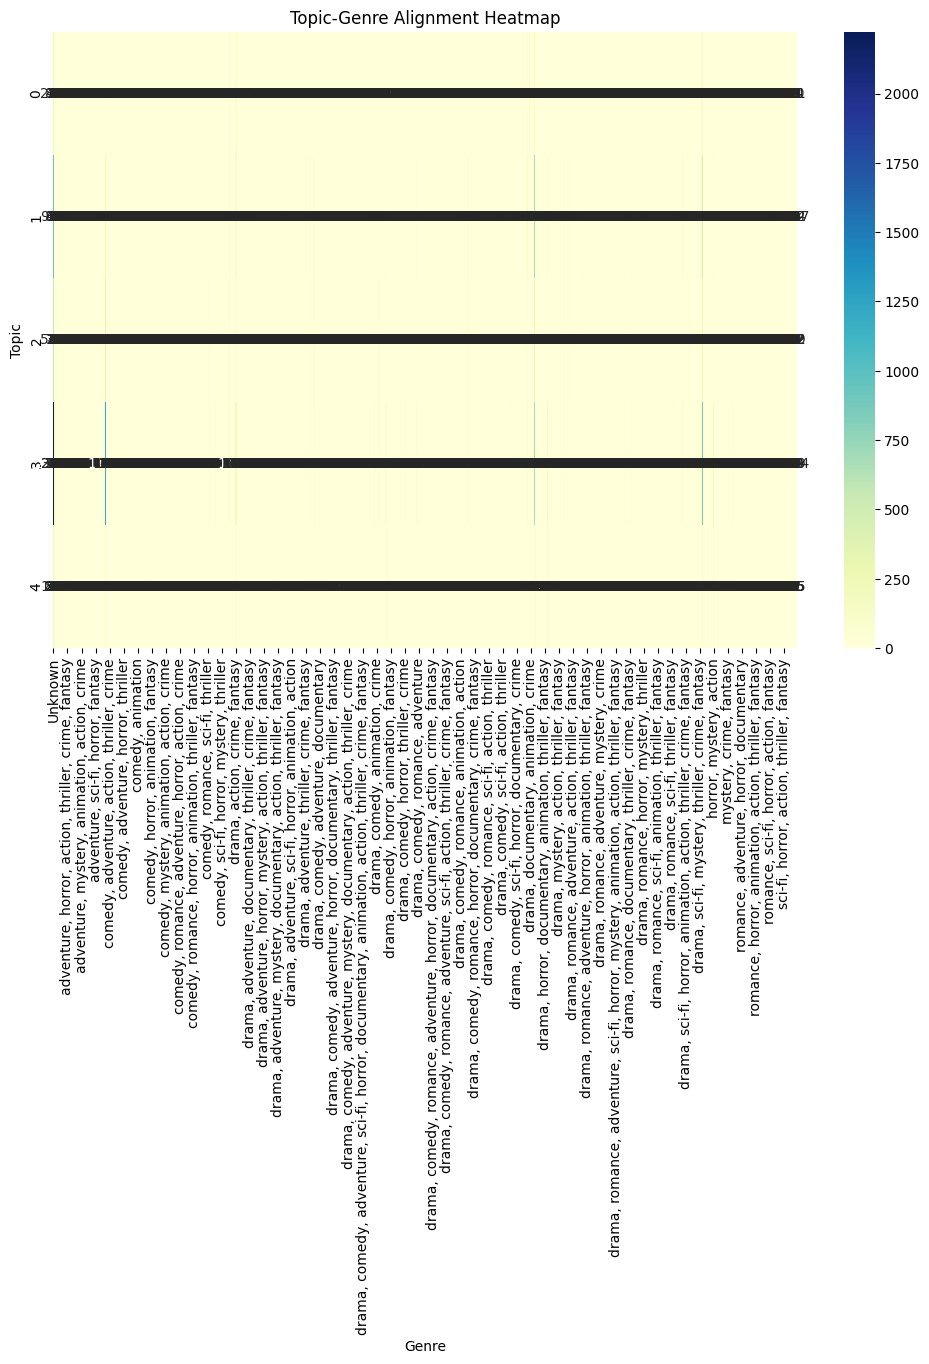

In [52]:
import seaborn as sns

# Frequency of genres by topics
topic_genre_counts = df.groupby(['Assigned_Topic_Sklearn', 'Genre']).size().unstack(fill_value=0)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(topic_genre_counts, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Topic-Genre Alignment Heatmap")
plt.xlabel("Genre")
plt.ylabel("Topic")
plt.show()


LDA Coherence Score:

In [53]:
# Step 1: Extract feature names from CountVectorizer
feature_names = count_vectorizer.get_feature_names_out()

# Step 2: Convert sklearn topics to Gensim format
lda_topics = [[feature_names[i] for i in topic.argsort()[:-10 - 1:-1]] for topic in lda_model_sklearn.components_]

# Step 3: Tokenize reviews (if not already done)
tokenized_reviews = [review.split() for review in df['review']]

# Step 4: Create Gensim dictionary (if not already done)
from gensim.corpora.dictionary import Dictionary
dictionary = Dictionary(tokenized_reviews)

# Step 5: Compute coherence score
from gensim.models.coherencemodel import CoherenceModel
coherence_model = CoherenceModel(topics=lda_topics, texts=tokenized_reviews, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"LDA Coherence Score: {coherence_score}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LDA Coherence Score: 0.37028536019802044


**Plot word clouds for each topic**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


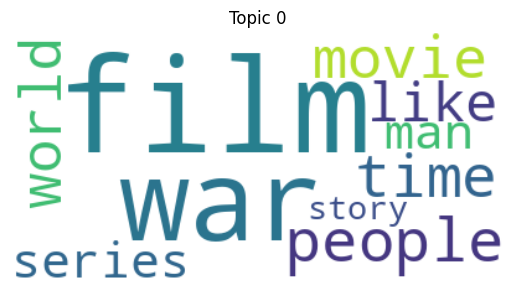

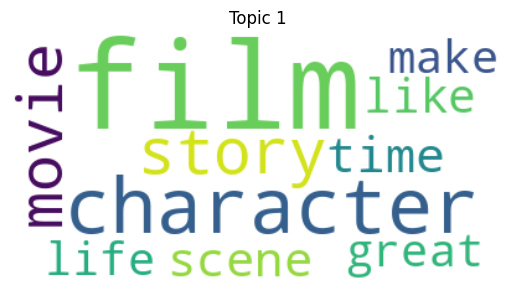

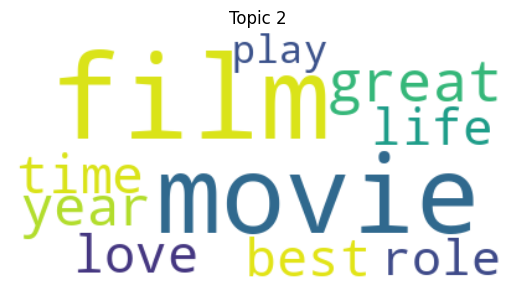

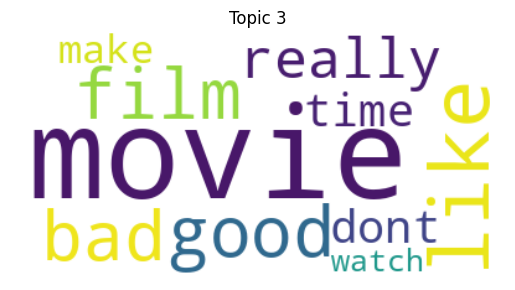

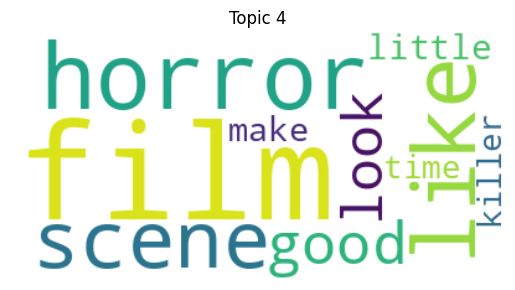

In [54]:
# Create and plot word clouds for each topic
for topic_idx, topic in enumerate(lda_model_sklearn.components_):
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(
        {feature_names[i]: topic[i] for i in topic.argsort()[:-10 - 1:-1]}
    )
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {topic_idx}")
    plt.show()


 Postive and Negative-reviewed movies by genre.




In [55]:
def display_best_positive_negative_reviews(genre, df):
    genre_reviews = df[df['Genre'] == genre]

    if genre_reviews.empty:
        print(f"No reviews found for the genre: {genre}")
        return

    # Separate positive and negative reviews
    positive_reviews = genre_reviews[genre_reviews['sentiment'] == 1]
    negative_reviews = genre_reviews[genre_reviews['sentiment'] == 1]

    # Display the best positive review (longest positive review)
    if not positive_reviews.empty:
        best_positive = positive_reviews.loc[positive_reviews['review'].str.len().idxmax()]
        print(f"\nBest Positive Review for Genre: {genre}")
        print(best_positive['review'])
    else:
        print(f"\nNo positive reviews found for Genre: {genre}")

    # Display the worst negative review (shortest negative review)
    if not negative_reviews.empty:
        worst_negative = negative_reviews.loc[negative_reviews['review'].str.len().idxmin()]
        print(f"\nWorst Negative Review for Genre: {genre}")
        print(worst_negative['review'])
    else:
        print(f"\nNo negative reviews found for Genre: {genre}")

# Example Usage
genre = "horror"
display_best_positive_negative_reviews(genre, df)



Best Positive Review for Genre: horror
love everything late al adamson directed long varied career possession nurse sherri stand head shoulder fun yet admittedly gradez schlockfests like horror blood monster dracula v frankenstein film actually scary saying youre going jump seat watch nurse sherri course pastiche element exorcist ruby carrie one nice eerie little horror movie common seventy cant put finger whats spooky film drip atmosphere ending dont worry wont spoil adamson producer sam sherman really nailed one doesnt matter whether nurse sherri calculated success happy accident jill jacobson likable outstanding hapless nurse becomes possessed spirit recently deceased cult leader bill roy shine brief role geoffrey land okay surly doctor boyfriend blaxploitative element profit bottom line cheap drivein flick actually contribute plot rather window dressing nurse sherri poverty row production show time set special effect etc still film heart mostly decent acting direction genuine chil

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
import pandas as pd

# Function to display all positive and negative reviews for a specific genre in table form
def display_reviews_table(genre, df):
    # Filter reviews by the specific genre
    genre_reviews = df[df['Genre'] == genre]

    if genre_reviews.empty:
        print(f"No reviews found for the genre: {genre}")
        return

    # Separate positive and negative reviews
    positive_reviews = genre_reviews[genre_reviews['sentiment'] == 1]['review'].reset_index(drop=True)
    negative_reviews = genre_reviews[genre_reviews['sentiment'] == 0]['review'].reset_index(drop=True)

    # Create a DataFrame for table format
    max_length = max(len(positive_reviews), len(negative_reviews))
    positive_reviews = positive_reviews.reindex(range(max_length), fill_value="No more positive reviews")
    negative_reviews = negative_reviews.reindex(range(max_length), fill_value="No more negative reviews")

    table = pd.DataFrame({
        'Positive Reviews': positive_reviews,
        'Negative Reviews': negative_reviews
    })

    # Display the table
    print(f"\nReviews for Genre: {genre}")
    display(table)  # Use display() in Jupyter Notebook or print() in a script

# Example Usage
genre = "action"
display_reviews_table(genre, df)



Reviews for Genre: action


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Positive Reviews,Negative Reviews
0,think one hell moviewe see steven fighting aro...,movie badly written directed acted beggar beli...
1,meryl streep genius well least actress know sh...,morning nothing else dont judge pleasewere bac...
2,first saw film around month ago considered int...,fan henriksen liked millennium series course l...
3,seven ups compared bullitt chase scene come an...,movie start good thing going movie thing go do...
4,enjoyed go said even bought movie dvd enjoyed ...,bulletproof quite clearly disposable film kind...
...,...,...
368,No more positive reviews,last minute movie would given movie score star...
369,No more positive reviews,im sorry say acting film horrible dialogue sou...
370,No more positive reviews,another french film absurdity baisemoifck tell...
371,No more positive reviews,ho hum another flick steven seagal pretending ...


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                                              review  \
0  one reviewer mentioned watching oz episode you...   
1  wonderful little production filming technique ...   
2  thought wonderful way spend time hot summer we...   
3  basically there family little boy jake think t...   
4  petter matteis love time money visually stunni...   

                                   Genre Movie_Rating  
0                   drama, action, crime      Neutral  
1                          drama, comedy      Neutral  
2  drama, comedy, romance, action, crime      Neutral  
3        drama, horror, action, thriller      Neutral  
4                                  drama      Neutral  


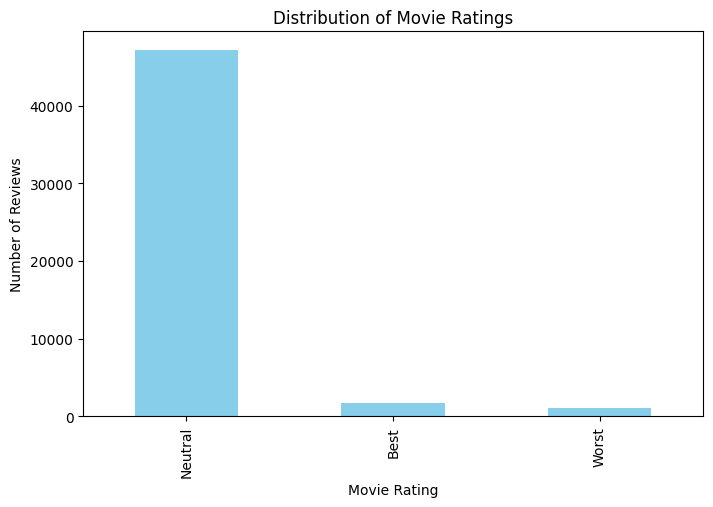

In [57]:
# Step 1: Calculate Sentiment Scores for Each Genre
genre_sentiment = df.groupby('Genre')['sentiment'].mean()

# Step 2: Determine Best and Worst Genres
best_genre_threshold = genre_sentiment.max() - (genre_sentiment.max() - genre_sentiment.min()) * 0.2
worst_genre_threshold = genre_sentiment.min() + (genre_sentiment.max() - genre_sentiment.min()) * 0.2

best_genres = genre_sentiment[genre_sentiment >= best_genre_threshold].index.tolist()
worst_genres = genre_sentiment[genre_sentiment <= worst_genre_threshold].index.tolist()

# Step 3: Assign Best or Worst Rating
def assign_movie_rating(genre):
    if genre in best_genres:
        return 'Best'
    elif genre in worst_genres:
        return 'Worst'
    else:
        return 'Neutral'

df['Movie_Rating'] = df['Genre'].apply(assign_movie_rating)

# Display the updated dataframe
print(df[['review', 'Genre', 'Movie_Rating']].head())

# Save the updated dataset with ratings
df.to_csv('reviews_with_movie_ratings.csv', index=False)

# Step 4: Visualize the distribution of ratings
import matplotlib.pyplot as plt

rating_counts = df['Movie_Rating'].value_counts()
rating_counts.plot(kind='bar', color='skyblue', figsize=(8, 5))
plt.xlabel('Movie Rating')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Movie Ratings')
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


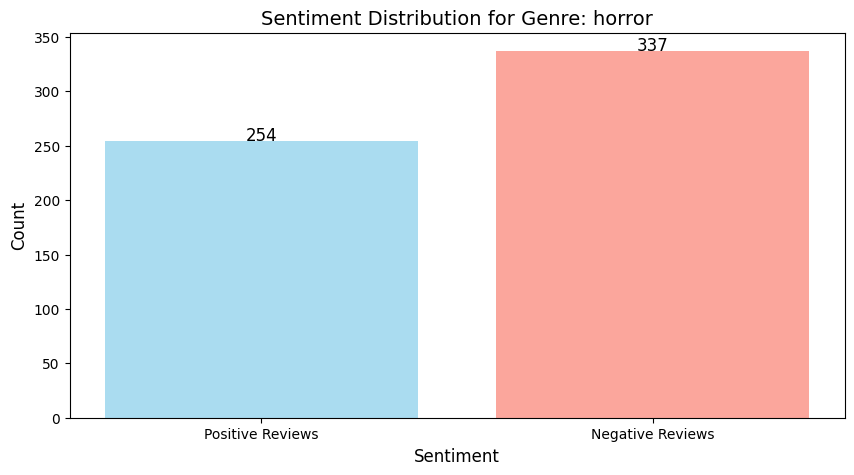

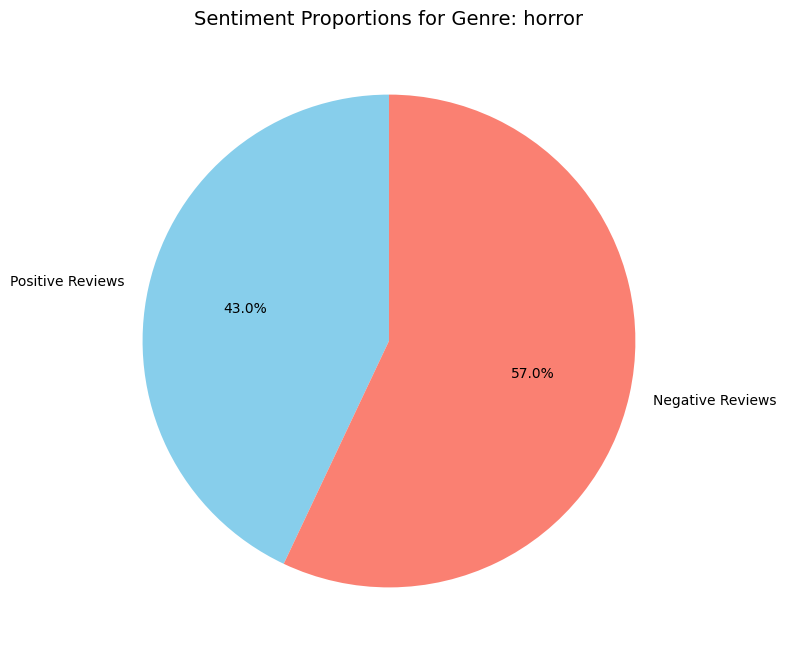

In [59]:
# Function to visualize positive and negative reviews for a specific genre
def visualize_reviews(genre, df):
    # Filter reviews by the specific genre
    genre_reviews = df[df['Genre'] == genre]

    if genre_reviews.empty:
        print(f"No reviews found for the genre: {genre}")
        return

    # Count positive and negative reviews
    sentiment_counts = genre_reviews['sentiment'].value_counts()
    labels = ['Positive Reviews', 'Negative Reviews']
    counts = [sentiment_counts.get(1, 0), sentiment_counts.get(0, 0)]

    # Bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(labels, counts, color=['skyblue', 'salmon'], alpha=0.7)
    plt.xlabel('Sentiment', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title(f"Sentiment Distribution for Genre: {genre}", fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    for i, count in enumerate(counts):
        plt.text(i, count + 1, str(count), ha='center', fontsize=12)
    plt.show()

    # Pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=['skyblue', 'salmon'], startangle=90)
    plt.title(f"Sentiment Proportions for Genre: {genre}", fontsize=14)
    plt.show()

# Example Usage
genre = "horror"
visualize_reviews(genre, df)
